In [1]:
import sys
sys.path.append("../darknet")

from detector import predict
import torch
import numpy as np
import os
import os.path as osp
from postprocess import postprocess
from args import arg_parse
from __future__ import division
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2
from util import *
import os
import os.path as osp
from darknet import Darknet
from preprocess import prep_image, inp_to_image
import pandas as pd
import random
import pickle as pkl
import itertools
from PIL import Image

In [2]:
crit_vals = {
    "iou": 0.9999,
    "cc": 0.9999,               # class_correspondence
    "id": 0.9999,               # initial dist 
    "vd": 0.9999                # vector dist
}

cm=None

In [3]:
class Args:
    def __init__(self):
        self.bs = 1
        self.confidence = .5
        self.cfgfile = "../darknet/cfg/yolov3.cfg"
        self.nms_thresh = .4
        self.weightsfile = "../yolov3.weights"
        self.images = None
        self.reso = "416"
        self.scales = "1,2,3"
        self.saveto = ""
        self.silent = None
        self.cuda = "3"
        self.det = "det"
        self.vot = "/home/zabulskyy/data/vot2016/"
        self.pp = "first_and_mfc_smart"
        self.saveto = "lol.txt"

In [4]:
def print_tensor(tensor):
    for row in tensor:
        print()
        for cell in row:
            print("{0}   ".format(cell), end="")
        print()
        

In [5]:
def print_pred(impath, prediction):
    im = Image.open(im_path)
    plt.imshow(im)
    plt.title(impath.split('/')[-1])
    for pr_bb in prediction[:, 1:5]:
        X, Y = pr_bb[::2], pr_bb[1::2]
        pr_bb = [min(X), min(Y), max(X),  max(Y)]
        plt.plot([pr_bb[0], pr_bb[2], pr_bb[2], pr_bb[0], pr_bb[0], ],
                             [pr_bb[1], pr_bb[1], pr_bb[3], pr_bb[3], pr_bb[1], ], 'r-', lw=2)

In [6]:
def predict_batch(batch, dim_list):
    im_dim_list, inp_dim, i = dim_list
    if CUDA:
        batch = batch.cuda()

    with torch.no_grad():
        prediction = model(Variable(batch), CUDA)

    prediction = write_results(
        prediction, confidence, num_classes, nms=True, nms_conf=nms_thesh)

    if type(prediction) == int:
        i += 1
        return None, im_dim_list
    
    prediction[:, 0] += i*batch_size

    for im_num, image in enumerate(imlist[i*batch_size: min((i + 1)*batch_size, len(imlist))]):
        im_id = i*batch_size + im_num
        objs = [classes[int(x[-1])] for x in prediction if int(x[0]) == im_id]
    
    i += 1

    if CUDA:
        torch.cuda.synchronize()
        
    im_dim_list = [x[2] for x in batches]
    im_dim_list = torch.FloatTensor(im_dim_list).repeat(1, 2)

    if CUDA:
        im_dim_list = im_dim_list.cuda()

    im_dim_list = torch.index_select(im_dim_list, 0, prediction[:, 0].long())
    scaling_factor = torch.min(inp_dim/im_dim_list, 1)[0].view(-1, 1)
    prediction[:, [1, 3]] -= (inp_dim - scaling_factor * im_dim_list[:, 0].view(-1, 1)) / 2
    prediction[:, [2, 4]] -= (inp_dim - scaling_factor * im_dim_list[:, 1].view(-1, 1)) / 2
    prediction[:, 1:5] /= scaling_factor

    for j in range(prediction.shape[0]):
        prediction[j, [1, 3]] = torch.clamp(
            prediction[j, [1, 3]], 0.0, im_dim_list[j, 0])
        prediction[j, [2, 4]] = torch.clamp(
            prediction[j, [2, 4]], 0.0, im_dim_list[j, 1])
    return prediction, im_dim_list

In [7]:
def eval_single_class_corr(cls1 : int, cls2 : int, correlations=cm):
    # calculate correlations between two classes
    def read_csv(file):
        with open(file, 'r') as file:
            l = file.read().split("\n")
            l.pop(-1)
            l = [[float(x) for x in y.split(",")[:-1]] for y in l]   
            return torch.tensor(l)
    
    if correlations is None:
        cm = read_csv("correlations.csv")
        correlations = cm
        
    return float(cm[cls1][cls2])

def vec_dist(vec1, vec2):
    
    dist = torch.nn.modules.PairwiseDistance()
    vd = None
    
    if len(vec1) > 80:
        vec1[torch.argmax(vec1[6:]) + 6] = 1
        vec2[torch.argmax(vec2[6:]) + 6] = 1
        vd = dist(vec1[6:].view([1, -1]), vec2[6:].view([1, -1]))
    else:
        vec1[torch.argmax(vec1)] = 1
        vec2[torch.argmax(vec2)] = 1
        vd = dist(vec1.view([1, -1]), vec2.view([1, -1])) 
    return vd

def iou(boxA, boxB):
    # IoU between two boxes
    boxA = boxA[1:5] if len(boxA) != 4 else boxA
    boxB = boxB[1:5] if len(boxB) != 4 else boxB

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    res = interArea / float(boxAArea + boxBArea - interArea)
    return res


def eval_energy(bb1, bb2, cv=crit_vals, ban_negative_cc=True):
    box1, box2 = bb1[1:5], bb2[1:5]
    cls1, cls2 = bb1[6:-2], bb2[6:-2]  # 5'th column is the precision of the bbox
    class1, class2 = int(cls1[-1]), int(cls2[-1])
    
    _iou = iou(box1, box2)
#     print("--------------")
#     print(_iou, box1, box2)
#     print("--------------")
    _cc = eval_single_class_corr(class1, class2)
    _vd = vec_dist(bb1, bb2)
    
    return {"iou": _iou, "cc": _cc, "vd": 1 / _vd}

def cebtf(frame1, frame2, cv=crit_vals, ban_negative_cc=True):  
    # calculate_energies_between_two_frames
    _boxes = torch.zeros((len(frame1)))
    _energies = torch.zeros((len(frame1)))
    for i in range(len(frame1)):
        max_energy = 0
        max_energy_index = 0
        
        ious = torch.zeros(len(frame2))
        ccs = torch.zeros(len(frame2))
        vds = torch.zeros(len(frame2))
        
        for j in range(len(frame2)):
            energy = eval_energy(frame1[i], frame2[j], cv=crit_vals, ban_negative_cc=ban_negative_cc)
            
            if ban_negative_cc and energy["cc"] < 0:        
                pass  # values are already 0
            else:          
                ious[j] = energy["iou"] * crit_vals["iou"]
                ccs[j] = energy["cc"] * crit_vals["cc"]
                vds[j] = energy["vd"] * crit_vals["vd"]
                
        # normalize
        ious = ious# / (torch.max(ious) + 1e-10)
        ccs = ccs# / (torch.max(ccs) + 1e-10)
        vds = vds / (torch.max(vds) + 1e-10)

#         print("ious: {}, ccs: {}, vds: {}".format(ious, ccs, vds))
        energies = sum((ious, ccs, vds))
#         print("energies:", energies)
        
        _boxes[i] = torch.argmax(energies)
        _energies[i] = torch.max(energies)
    return _boxes, _energies
          

In [8]:
def select(preds, bboxes, energies):
    # do dynamic programming
    # core function 
    
    if CUDA:
        dpreds, bboxes = preds.cuda(), bboxes.cuda()
        
    if preds.shape[0] == 0: 
        print("NO PREDS")
        return bboxes, energies
    
    boxes, energy = cebtf(bboxes, preds)
    energies += energy
    
    return preds[boxes.long()], energies

In [9]:
args = Args()
vot_path = args.vot
saveto = args.saveto
# pp = None if args.pp.lower() == "none" else args.pp

cuda_n = int(args.cuda)
silent = args.silent == "all"
if (silent):
    import sys
    sys.stdout = open(os.devnull, 'w')
batch_size = int(args.bs)
confidence = float(args.confidence)
nms_thesh = float(args.nms_thresh)
start = 0

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = args.cuda

CUDA = torch.cuda.is_available()

classes = load_classes('../data/coco.names')
num_classes = len(classes)

# Set up the neural network
print("Loading network.....")
model = Darknet(args.cfgfile)
model.load_weights(args.weightsfile)
print("Network successfully loaded")

model.net_info["height"] = args.reso
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0
assert inp_dim > 32

# If there's a GPU availible, put the model on GPU
if CUDA:
    model.cuda()

# Set the model in evaluation mode
model.eval()
print()
# Detection phase

vot_path = args.vot
saveto = args.saveto

folder = "birds2"

result = dict()
num_frames = dict()

images = osp.join(vot_path, folder)
if (not os.path.isdir(images)):
    print(folder, "is not a folder")
    exit()

print("processing {}".format(folder))

try:
    imlist = [osp.join(osp.realpath('.'), images, img) for img in sorted(
        os.listdir(images))[:] if os.path.splitext(
        img)[1] == '.png' or os.path.splitext(
        img)[1] == '.jpeg' or os.path.splitext(img)[1] == '.jpg']
except NotADirectoryError:
    imlist = []
    imlist.append(osp.join(osp.realpath('.'), images))
except FileNotFoundError:
    print("No file or directory with the name {}".format(images))
    exit()

num_frames[folder] = len(imlist)

batches = list(
    map(prep_image, imlist, [inp_dim for x in range(len(imlist))]))
im_batches = [x[0] for x in batches]
orig_ims = [x[1] for x in batches]

if batch_size != 1:
    num_batches = len(imlist) // batch_size + leftover
    im_batches = [torch.cat((
        im_batches[i*batch_size: min((i + 1)*batch_size,
        len(im_batches))])) for i in range(num_batches)]
    

Loading network.....
Network successfully loaded

processing birds2


/home/zabulskyy/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


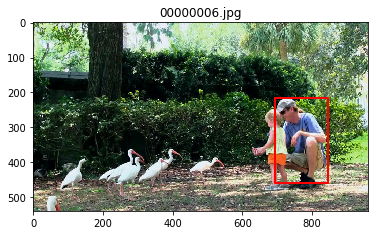

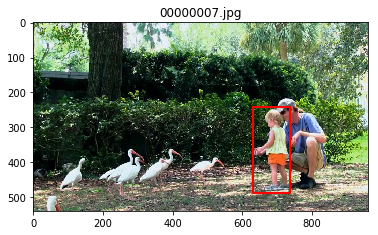

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [24]:
k = 5
# current_state

im_dim_list = [x[2] for x in batches]
im_dim_list = torch.FloatTensor(im_dim_list).repeat(1, 2)

prev_predictions, im_dim_list = predict_batch(im_batches[0], (im_dim_list, inp_dim, 0))
energies = torch.zeros(prev_predictions.shape[0])

for i, batch in enumerate(im_batches):
    if i == 0: continue
    if i % 10 and i < k: continue
    '''=====detection pahse====='''
    prediction, im_dim_list = predict_batch(batch, (im_dim_list, inp_dim, i))
    if prediction is None: continue
    
    '''=====selection phase=====''' 
    prediction, energies = select(prediction, prev_predictions, energies)
    prev_predictions = prediction
    hero = prediction[torch.argmax(energies)][1:5]
    
    '''=====plotting====='''
    image = imlist[i]
    im = Image.open(image)
    plt.imshow(im)
    plt.title(image.split('/')[-1])
    if i < k:
        for pr_bb in prediction[:, 1:5]:
            X, Y = pr_bb[::2], pr_bb[1::2]
            pr_bb = [min(X), min(Y), max(X),  max(Y)]
            plt.plot([pr_bb[0], pr_bb[2], pr_bb[2], pr_bb[0], pr_bb[0], ],
                                 [pr_bb[1], pr_bb[1], pr_bb[3], pr_bb[3], pr_bb[1], ], 'b-', lw=2)
    else:
        X, Y = hero[::2], hero[1::2]
        pr_bb = [min(X), min(Y), max(X),  max(Y)]
        plt.plot([pr_bb[0], pr_bb[2], pr_bb[2], pr_bb[0], pr_bb[0], ],
                             [pr_bb[1], pr_bb[1], pr_bb[3], pr_bb[3], pr_bb[1], ], 'r-', lw=2)
    plt.show()
    plt.clf()
    